In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
a=pd.read_csv('/content/drive/MyDrive/train (1).csv')
b=pd.read_csv('/content/drive/MyDrive/test (1).csv')

In [ ]:
train=pd.DataFrame(a)
test=pd.DataFrame(b)

In [ ]:
df = pd.concat([train,test], ignore_index=True)

In [ ]:
import pickle
dt=pickle.load(open('/content/drive/MyDrive/dt_model.sav','rb'))

In [ ]:
lr=pickle.load(open('/content/drive/MyDrive/LR_model.sav','rb'))

In [ ]:
svm=pickle.load(open('/content/drive/MyDrive/SVM_modell.sav','rb'))

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
def create_cnn_model():
  meta_model = Sequential()
  meta_model.add(Dense(64, activation='relu', input_shape=(3,)))
  meta_model.add(Dropout(0.2))
  meta_model.add(Dense(1, activation='sigmoid'))
  meta_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return meta_model

In [ ]:
#Creating a k-fold wi
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
stacked_predictions = []
true_labels = []

In [ ]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [ ]:
def modeltrain(X_train):
  svm_pred = svm.predict(X_train)
  dt_pred = dt.predict(X_train)
  lr_pred = lr.predict(X_train)
  s=np.column_stack((svm_pred, dt_pred,lr_pred))
  return s

In [ ]:
def modeltest(X_train):
  svm_pred = svm.predict(X_train)
  dt_pred = dt.predict(X_train)
  lr_pred = lr.predict(X_train)
  s=np.column_stack((svm_pred, dt_pred,lr_pred))
  return s

In [20]:
import time
import os
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [26]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
execution_times = []

# Loop over the K-Fold splits
for train_index, val_index in skf.split(X, y):
    X_train, X_val = [], []
    y_train, y_val = [], []

    # Prepare training and validation data
    for i in train_index:
        X_train.append(X.iloc[i])
        y_train.append(y.iloc[i])
    y_train = np.array(y_train)

    for i in val_index:
        X_val.append(X.iloc[i])
        y_val.append(y.iloc[i])
    y_val = np.array(y_val)

    # Create and train the CNN model
    meta_X_train = modeltrain(X_train)
    meta_model = create_cnn_model()

    start_time = time.time()
    meta_model.fit(meta_X_train, y_train, epochs=10, batch_size=32, verbose=0)
    end_time = time.time()
    execution_times.append(end_time - start_time)

    # Test the model on validation data
    meta_X_val = modeltest(X_val)
    predictions = (meta_model.predict(meta_X_val) > 0.5).astype("int32")

    # Calculate metrics
    accuracy = accuracy_score(predictions, y_val)
    precision = precision_score(predictions, y_val)
    recall = recall_score(predictions, y_val)
    f1 = f1_score(predictions, y_val)
    roc_auc = roc_auc_score(predictions, y_val)

    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print the accuracy for each fold
    print("Accuracy for Fold {}: {}".format(len(accuracy_scores), accuracy))

52/52 [==============================] - 0s 1ms/step
Accuracy for Fold 1: 0.9908759124087592
52/52 [==============================] - 0s 2ms/step
Accuracy for Fold 2: 0.9854014598540146
52/52 [==============================] - 0s 1ms/step
Accuracy for Fold 3: 0.9829580036518564
52/52 [==============================] - 0s 1ms/step
Accuracy for Fold 4: 0.9860012172854534
52/52 [==============================] - 0s 1ms/step
Accuracy for Fold 5: 0.9835666463785758


In [23]:
# Calculate average metrics over K-Fold
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_roc_auc = np.mean(roc_auc_scores)
avg_execution_time = np.mean(execution_times)
print()
# Print average metrics
print("Average Accuracy: {}".format(avg_accuracy))
print("Average Precision: {}".format(avg_precision))
print("Average Recall: {}".format(avg_recall))
print("Average F1 Score: {}".format(avg_f1))
print("Average ROC AUC: {}".format(avg_roc_auc))
print("Average Execution Time: {} seconds".format(avg_execution_time))


Average Accuracy: 0.9857606479157319
Average Precision: 0.9291585610622202
Average Recall: 0.977787564430912
Average F1 Score: 0.9526802441112221
Average ROC AUC: 0.9824820105322326
Average Execution Time: 5.770787715911865 seconds


52/52 [==============================] - 0s 5ms/step


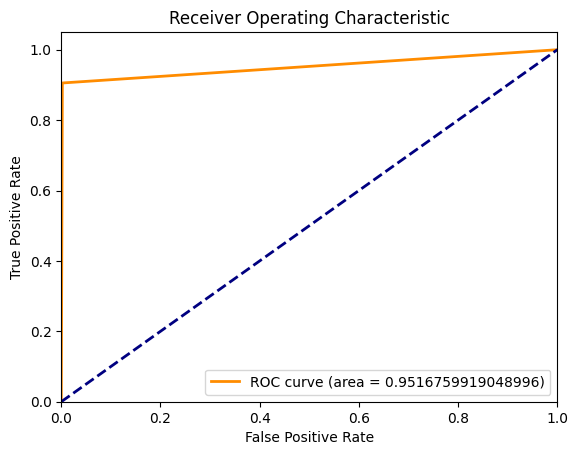

In [24]:
last_val_index = val_index
X_val_last = []
y_val_last = []
for i in last_val_index:
    X_val_last.append(X.iloc[i])
    y_val_last.append(y.iloc[i])
y_val_last = np.array(y_val_last)

meta_X_val_last = modeltest(X_val_last)
predictions_last = (meta_model.predict(meta_X_val_last) > 0.5).astype("int32")


# Calculate and plot ROC curve and AUC for the last fold
fpr, tpr, _ = roc_curve(y_val_last, predictions_last)
roc_auc = roc_auc_score(y_val_last, predictions_last)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Save the model
meta_model.save("meta_model.h5")

In [25]:
# Calculate model size in MB
model_size_bytes = os.path.getsize("meta_model.h5")
model_size_mb = model_size_bytes / (1024 * 1024)
print("Model Size: {} MB".format(model_size_mb))

Model Size: 0.02783203125 MB
